<a href="https://colab.research.google.com/github/bending456/Macrophage/blob/master/NetworkX_101320.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Before you start 

Please, make sure you copy this to script to your google drive by clicking the button shown in the image below. 

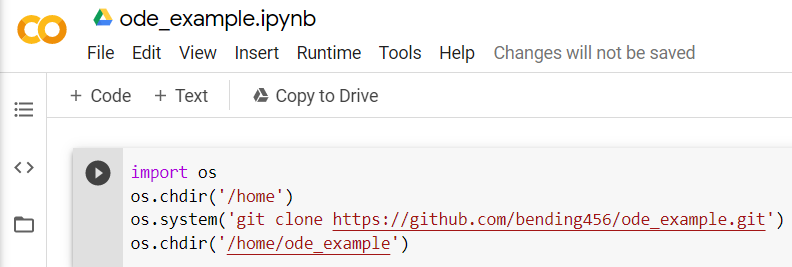

### Downloading files 
- Network: in sif format  
- mRNA seq: in csv format 
- protein expression obtained by Chris: in csv format

In [ ]:
import os
os.chdir('/home')
os.system('git clone https://bending456@bitbucket.org/pkhlab/pathwayanalysis.git')
os.chdir('/home/pathwayanalysis') ## <------ This is your working directory so click the folder symbol to navigate it

### Installing NetworkX package 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.system('apt-get install graphviz libgraphviz-dev pkg-config')
!pip3 install networkx
!pip3 install pygraphviz
!pip3 install graphviz

     |████████████████████████████████| 122kB 4.7MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.6-cp36-cp36m-linux_x86_64.whl size=155462 sha256=458494fd467d6dc7308089c0fd2b4cb085c2611d43c94dbe16a028ed43ac76e4
  Stored in directory: /root/.cache/pip/wheels/7c/45/a1/93b830b69fb81d1ae84a248da30e2c0b926a3a6e3435908e6d
Successfully built pygraphviz


### Loading up required packages for analysis 

In [ ]:
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

#### Step1: Importing mRNA seq data from csv format 
- 1st column: name of mRNA (will be compared against the node name from the pathway)
- 2nd column: M1 expression
- 3rd column: M2 expression
- 4th column: M1M2 expression (repolarized M1)
- 5th column: P-Value 
- 6th column: M1M2 vs. M1 in logFC 
- 7th column: M1M2 vs. M2 in logFC 

You can also check this by print out the first raw of data set



In [ ]:
# Loading CSV file for mRNA seq data
mrnadata = open('mRNAdata.csv','r')

# Empty dictionary for each column
data_mrna = {}
counter = 0

for line in mrnadata:
  if line.strip():
    if counter == 0:
      counter = counter + 1 
      column_names = line.strip("\n' '")
      data_name = line.split(",")
      # Creating the dictionary data structure
      for name in data_name:
        data_mrna[name]=[]
    else:
      line = line.strip("\n' '")
      line = line.split(",")
      # Storing the data in the dictionary 
      for i in np.arange(7):
        element = line[i]
        data_mrna[data_name[i]].append(element)

mrnadata.close()

In [ ]:
print(data_mrna)

{'mgi_symbol': ['Ighm', 'Slco2b1', 'Myh10', 'Rnase6', 'Lifr', 'Slc22a4', 'Mxd4', 'Cx3cr1', 'Mex3b', 'Itga4', 'Chrm3', 'Cenpf', 'Card11', 'Dpy19l1', 'Pdpn', 'Klhl6', 'Procr', 'C4b', 'St8sia4', 'Naip1', 'Pole', 'Camk1d', 'Hyal1', 'Aspm', 'Gpr155', 'Clec9a', 'Il12rb2', 'Racgap1', 'A530064D06Rik', 'Hmox1', 'Kif11', '2810417H13Rik', 'Sh2b2', 'Ccnb2', 'Tmem176b', 'Top2a', 'Tlr12', 'Clec1a', 'Tlr11', 'Ptgs1', 'Uhrf1', 'Hdac9', 'Gde1', 'Cyp4f18', 'Kif14', 'Tarm1', 'Kntc1', 'Plk1', 'E2f7', 'Prr11', 'Ctse', 'Kif18b', 'Ccr2', 'Ccna2', 'Neil3', 'Arap3', 'Pkib', 'Asgr2', 'Mcoln2', 'Tma16', 'Fth1', 'Psd3', 'Knstrn', 'Pak1', 'Aurkb', 'Alms1', 'Hist1h2af', 'Kif20a', 'Man2b1', 'Ncapd2', 'Traf3ip3', 'Tle1', 'Egr3', 'Cit', 'Ckap2l', 'Sgpp1', 'Map3k5', 'Cmah', 'Hist1h3c', 'Rnf128', 'Cd200', 'Hist1h3b', 'Nusap1', 'Abca9', 'Mef2c', 'Chd3', 'Agmo', 'Naaa', 'Kif4', 'Deptor', 'F10', 'Hilpda', 'Troap', 'Sdc1', 'Ube2c', 'Clec10a', 'Anln', 'Etl4', 'Kif23', 'Kcnd1', 'Pbk', 'Mcm5', 'Gm6977', 'Cdc42ep3', 'Dmpk', 'Fo

#### Step1-a: Check the names of columns

#### Step2: Importing Network file

In [ ]:
# Loading SIF file for pathway data
'''
smaller network-> fullpicture_refined
extended network-> expanded_IL6_modified_receptor
'''
input_file_name = 'expanded_IL6_modified_receptor'
infile = open(input_file_name+'.sif','r')
'''
The data structure for pathway (sif format) is 
source_node type_of_edge  target_node
Therefore, the element of data is in string (no numerical data in this file)
'''
data_network = {}
network_info = ['start_nodes','edge_features','end_nodes','receptor_switch']
counter = 0

for line in infile:
  if line.strip():
    line = line.strip("\n' '")
    line = line.split("	")

    if counter == 0:
      counter = counter + 1 
      for name in network_info:
        data_network[name]=[]

    for i in np.arange(len(network_info)):
      data_network[network_info[i]].append(line[i])

infile.close()

#### Step2-a: sorting unique name of node and edge type


In [ ]:
node_names = np.unique(data_network['start_nodes']+data_network['end_nodes']) ## get unique node name
edge_unique_feature = np.unique(data_network['edge_features']) ## get unique edge feature
print(edge_unique_feature)

['down-regulates' 'up-regulates']


#### Step2-b: assigning the weight for each edge type
- up-regulatory: 1 
- down-regulatory: 1000

This scale is assigned to differentiate between up- and down-regulatory edge.

This is something we should further implement 


In [ ]:
edge_weight_dict = {}
for i in np.arange(len(edge_unique_feature)):
    if edge_unique_feature[i] == 'down-regulates':
        w = [1000,'D']
        edge_weight_dict[edge_unique_feature[i]] = w
    elif edge_unique_feature[i] == 'up-regulates':
        w = [1,'U']
        edge_weight_dict[edge_unique_feature[i]] = w


print(edge_weight_dict)

{'down-regulates': [1000, 'D'], 'up-regulates': [1, 'U']}


#### Step3: Constructing Network

In [ ]:
G = nx.DiGraph()

for node in node_names:
    G.add_node(node)
    
G.nodes()

for n in np.arange(len(data_network['start_nodes'])):
    weight = edge_weight_dict[data_network['edge_features'][n]][0]
    label_n = edge_weight_dict[data_network['edge_features'][n]][1]
    G.add_edge(data_network['start_nodes'][n],data_network['end_nodes'][n],weight=weight,label=label_n)
    
G.edges()

OutEdgeView([('AKT', 'mTORC1'), ('AKT', 'IKK-complex'), ('AKT', 'M2_polarization'), ('Anti-CD81', 'CD81'), ('BIRC2', 'TRAF2'), ('BRAF', 'MEK1/2'), ('CCL5', 'CCR3'), ('CCR3', 'PI3K '), ('CCR3', 'JAK2'), ('CD40', 'TRAF3'), ('CD40', 'TRAF2'), ('CD40LG', 'CD40'), ('CD81', 'PI3K'), ('CHUK', 'NFKB2'), ('CHUK', 'MAP3K14'), ('CTF1', 'LIFR'), ('CTF1', 'IL6ST'), ('CYLD', 'TRAF2'), ('DAMPS', 'TLR4'), ('EGF', 'EGFR'), ('EGFR', 'GRB2'), ('EGFR', 'GAB1'), ('ELK1', 'M2_polarization'), ('ERK1/2', 'BRAF'), ('ERK1/2', 'ELK1'), ('ERK1/2', 'RPS6K'), ('ERK1/2', 'GAB1'), ('FADD', 'RIPK1'), ('FAS', 'FADD'), ('FASLG', 'FAS'), ('GAB1', 'PI3K'), ('GRB2', 'SOS1'), ('HRAS', 'BRAF'), ('IFNG', 'IFNGR2'), ('IFNG', 'IFNGR1'), ('IFNG', 'NfKb-p65/p50'), ('IFNGR1', 'JAK2'), ('IFNGR2', 'JAK2'), ('IKBKE', 'NfKb-p65/p50'), ('IKBKE', 'IRF3'), ('IKBKE', 'NFKBIA'), ('IKBKG', 'IKK-complex'), ('IKK-complex', 'NfKb-p65/p50'), ('IL10', 'IL10RA'), ('IL10RA', 'JAK2'), ('IL13', 'IL4R'), ('IL1A', 'IL1R1'), ('IL1B', 'IL1R1'), ('IL1R1'

#### Step3-a: For the better visualization with properly spaced out labels 
- the location of png file is the same as where raw data files are located

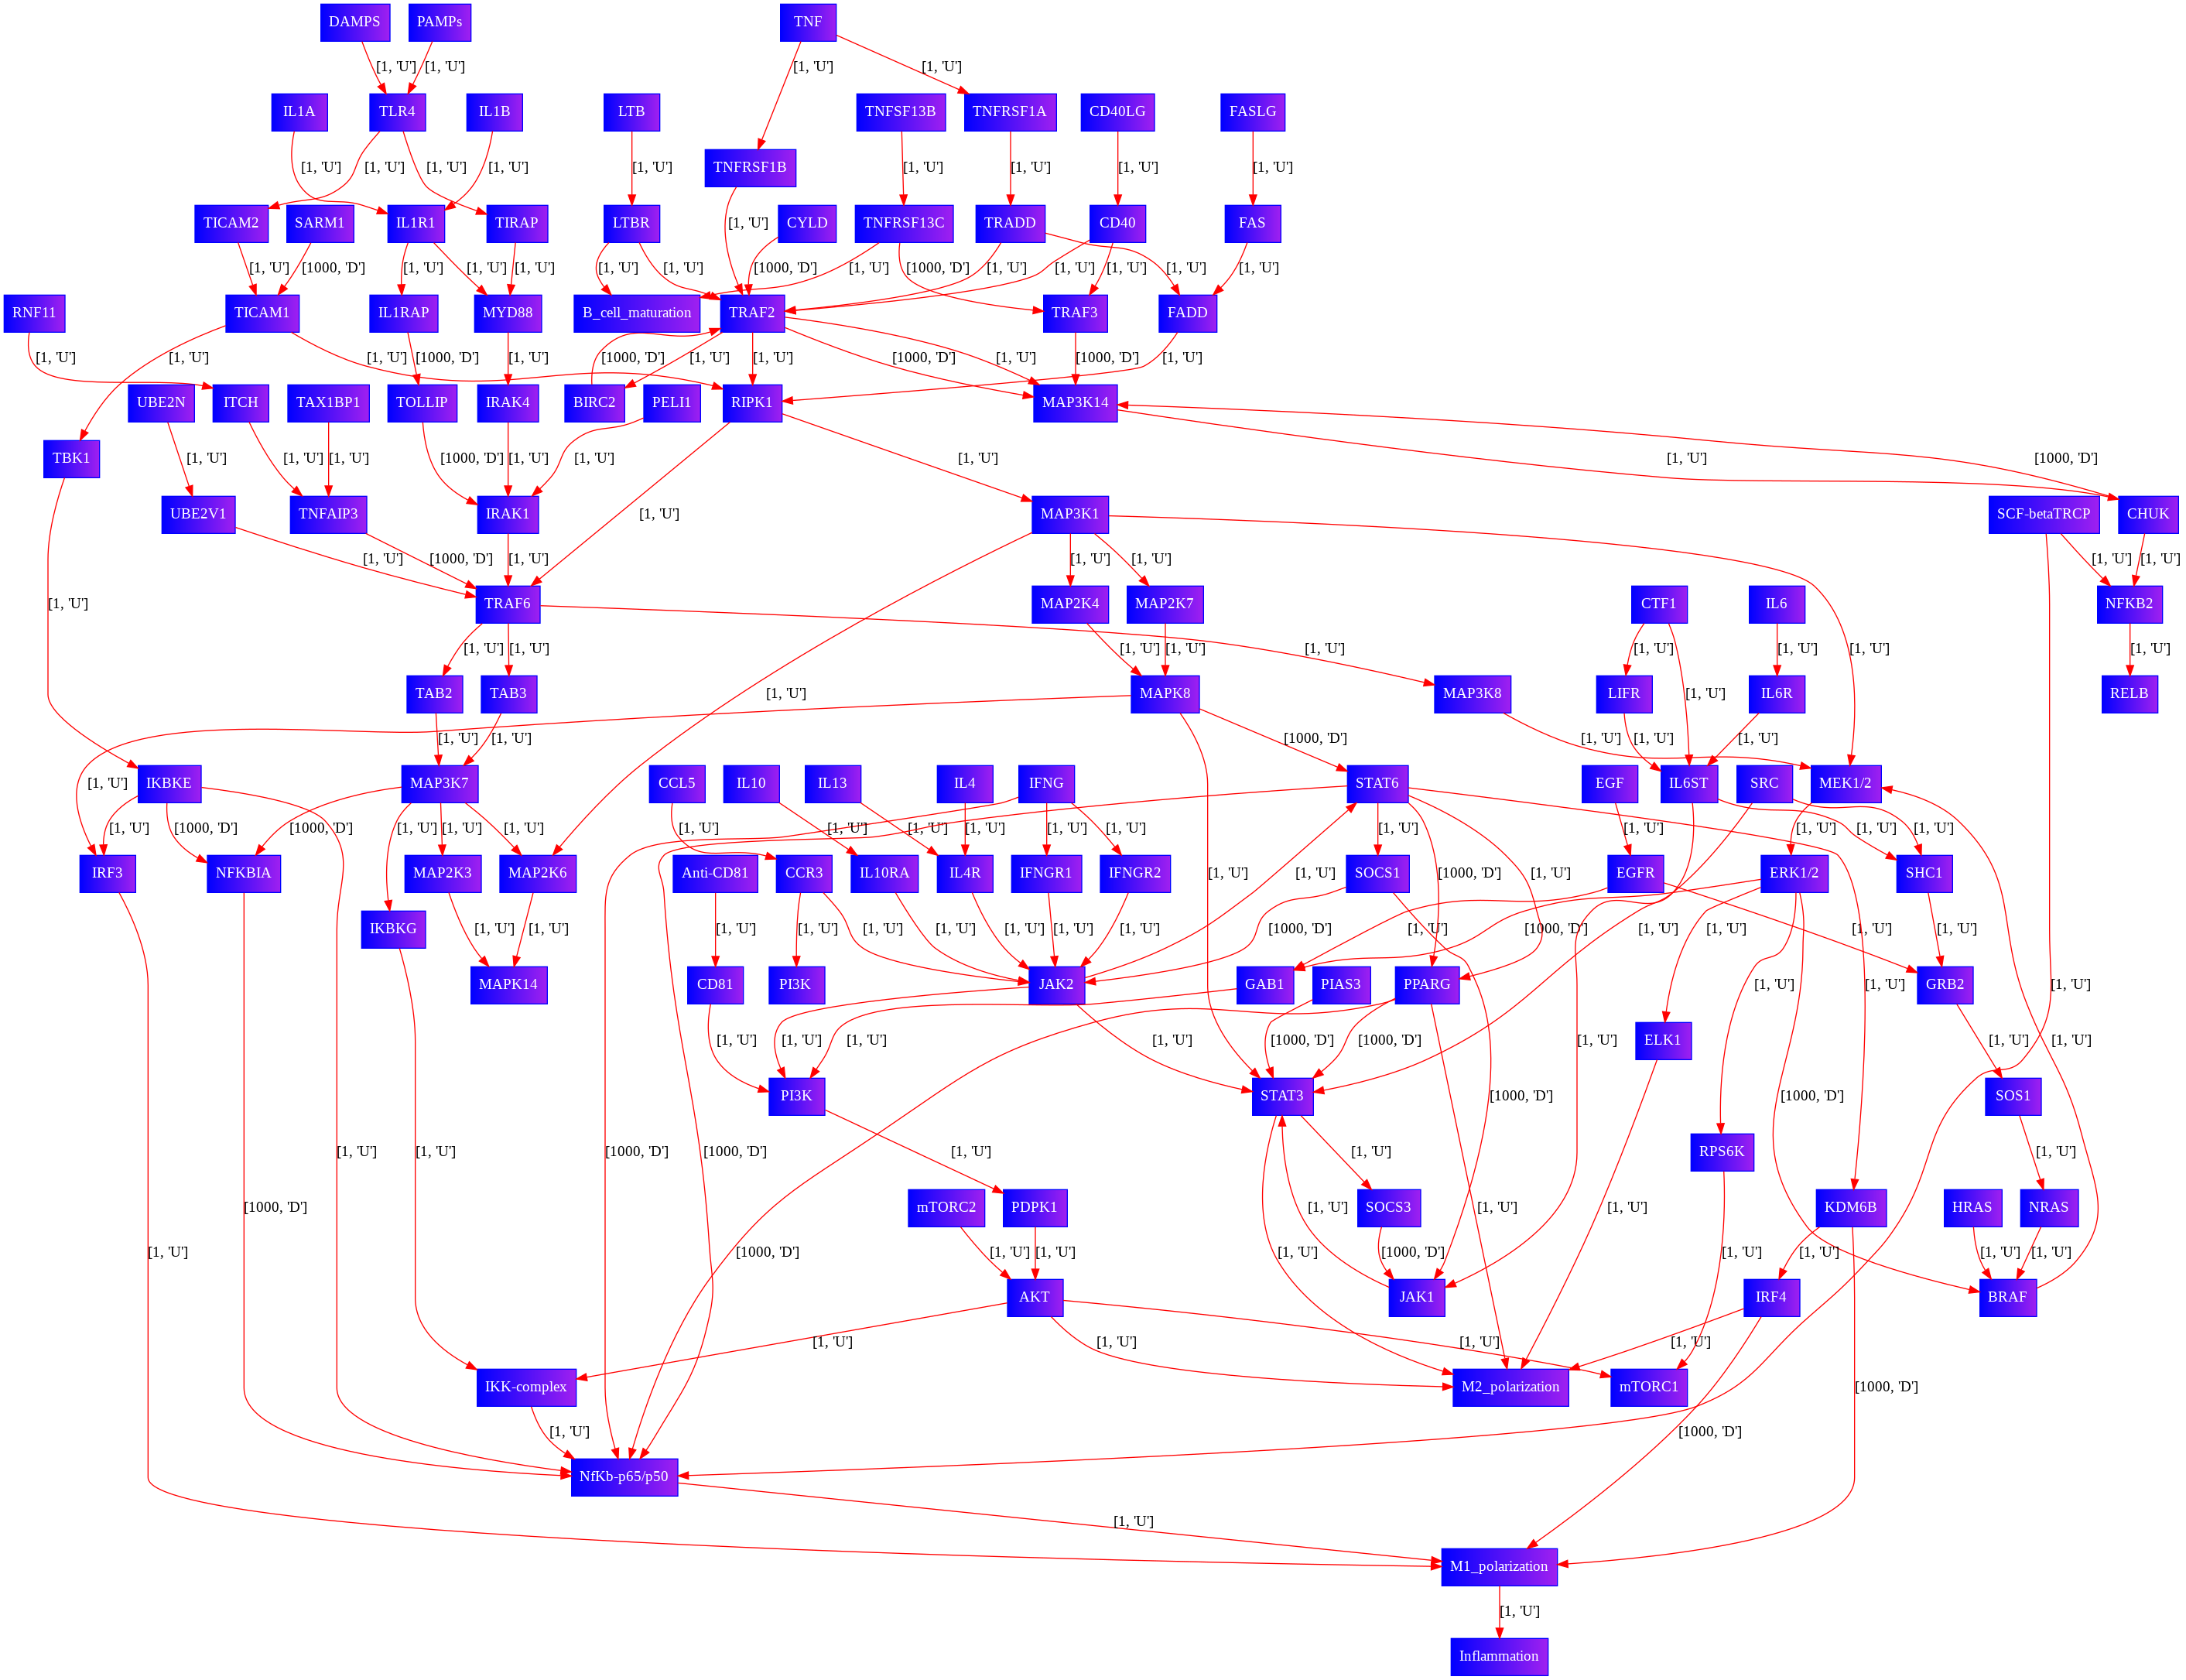

In [ ]:
from graphviz import Digraph

G2 = Digraph('unix', filename='fullpicture',format='png',
            node_attr={'shape':'box','color': 'blue:purple', 'style': 'filled','fontcolor':'white'},
            edge_attr={'color': 'red'})

for node in node_names:
    G2.node(node)

for n in np.arange(len(data_network['start_nodes'])):
    weight = edge_weight_dict[data_network['edge_features'][n]]
    G2.edge(data_network['start_nodes'][n],data_network['end_nodes'][n],label=str(weight))

G2.view()

from IPython.display import Image
Image(filename='fullpicture.png') 

#### Step4: Analyzing pathways
##### M1 polarization-related pathway 

In [ ]:
# List the name of receptor(node) to analyze 
counter = 0
Receptors =[]
for switch in data_network['receptor_switch']:
  if switch == 'true':
    Receptors.append(data_network['start_nodes'][counter])
  counter += 1
Receptors = np.unique(Receptors)
print('List of Receptors in the pathway network')
print(Receptors)

# Final outcome of your interest
Outcome = 'M1_polarization'
pathDict = {}
pathScore = {}

for R in Receptors:
  try:
    Path = nx.dijkstra_path(G,R,Outcome)
    pathDict[R] = Path
    Score = nx.dijkstra_path_length(G,R,Outcome)
    pathScore[R] = Score
    print('The shortest path from ',R,' (Upstream Receptor) to Inflammation in a weighted Pathway Network: \n', Path,'\n with score of ',Score,'\n')
  except:
    pass
  
  

List of Receptors in the pathway network
['CCR3' 'CD40' 'CD81' 'EGFR' 'FAS' 'IFNGR1' 'IFNGR2' 'IL10RA' 'IL1R1'
 'IL4R' 'IL6R' 'LIFR' 'LTBR' 'TLR4' 'TNFRSF13C' 'TNFRSF1A' 'TNFRSF1B']
The shortest path from  CCR3  (Upstream Receptor) to Inflammation in a weighted Pathway Network: 
 ['CCR3', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'] 
 with score of  7 

The shortest path from  CD40  (Upstream Receptor) to Inflammation in a weighted Pathway Network: 
 ['CD40', 'TRAF2', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'IRF3', 'M1_polarization'] 
 with score of  7 

The shortest path from  CD81  (Upstream Receptor) to Inflammation in a weighted Pathway Network: 
 ['CD81', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'] 
 with score of  6 

The shortest path from  EGFR  (Upstream Receptor) to Inflammation in a weighted Pathway Network: 
 ['EGFR', 'GAB1', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'] 
 with scor

In [ ]:
print(pathDict)

{'CCR3': ['CCR3', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'CD40': ['CD40', 'TRAF2', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'IRF3', 'M1_polarization'], 'CD81': ['CD81', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'EGFR': ['EGFR', 'GAB1', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'FAS': ['FAS', 'FADD', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'IRF3', 'M1_polarization'], 'IFNGR1': ['IFNGR1', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'IFNGR2': ['IFNGR2', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'IL10RA': ['IL10RA', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'IL1R1': ['IL1R1', 'MYD88', 'IRAK4', 'IRAK1', 'TRAF6', 'TAB2', 'MAP3K7', 'IKBKG', 'IKK-complex', 'NfKb-p65/p50', 'M1_polarization'], 'IL4R': ['IL4R', 'JAK2', 'PI3K', 'PDPK1', 'AKT', 'IKK-complex', 'NfKb-p65/p50', '

#### Step4-a: Checking the expression in M2 and Repolarized M1 macrophage


In [ ]:
# Loading CSV file for mRNA seq data
protdata = open('Ab_Chris.csv','r')

# Empty dictionary for each column
prot_data = {}
name_from_prot = []
counter = 0

for line in protdata:
  if line.strip():
    if counter == 0:
      counter = counter + 1
      continue 
    else:
      line = line.strip("\n' '")
      line = line.split(",")
      # Storing the data in the dictionary 
      if line[1] == "N/A":
        continue
      else:
        prot_data[line[1]] = float(line[2])
        name_from_prot.append(line[1])

protdata.close()

In [ ]:
print(name_from_prot)

['AKT', 'AKT', 'BRAF', 'PDPK1', 'CAK2', 'EGFR', 'ELK1', 'GAB1', 'IKBKE', 'CHUK', 'IKK-complex', 'IKK-complex', 'IL10RA', 'IL4R', 'IFNGR2/IFNGR1', 'JAK1', 'JAK2', 'MAP3K7', 'MEK1/2', 'MAP2K4', 'mTORC2', 'Nfkb-p65/p50', 'ERK1/2', 'PDPK1', 'PI3K', 'PPARG', 'RELB', 'SRC', 'STAT3', 'STAT6']


In [ ]:
def exp_checker(Receptor_name):
  List_path_nodes = pathDict[Receptor_name]
  print('Checking the expression of each node from mRNA seq data for ', Receptor_name,'-mediated pathway')
  M2Score = 0
  PolarizeScore = 0
  prot_exp_score = 0
  for node in List_path_nodes:
    for g_name in data_mrna['mgi_symbol']:
      if node.lower() == g_name.lower():
        n = data_mrna['mgi_symbol'].index(g_name)
        expM2 = float(data_mrna['M2'][n])
        compFC = float(data_mrna['logFC(M1M2/M2)\n'][n])
        print('- Name of Node: ', node)

        #for p_name in name_from_prot:
        #  if p_name.lower() == g_name.lower():
        #    prot_exp_val = prot_data[p_name]
        #    if prot_exp_val < 1:
        #      prot_exp_val = prot_data[p_name]*-1
        #      print(p_name)
        #      print(prot_exp_val)
        #  else:
        #    prot_exp_val = 0


        if float(expM2) < 0.001:
          continue
        else:
          M2Score = M2Score + expM2
          PolarizeScore = PolarizeScore + compFC
          #prot_exp_score += prot_exp_val
          print('-- Expression in M2: ', expM2)
          print('-- Fold Change from M2 to M1M2: ', compFC)
          #print('-- Fold Change from Protein Expression: ',prot_exp_val)

    for p_name in name_from_prot:
      if p_name.lower() == node.lower():
        prot_exp = 1/prot_data[p_name]
        if prot_exp_val < 1:
          prot_exp_val = prot_exp*-1
    
        prot_exp_score += prot_exp_val
        print(p_name)
        print('-- Fold Change from Protein Expression: ',prot_exp_val)
      else:
        prot_exp_val = 0
      
  
  pathscore = pathScore[Receptor_name]
  if pathscore > 1000:
    pathscore = -1000
  else:
    pathscore = np.log10(1/pathscore)

  total = 0.1*M2Score + 10*PolarizeScore + pathscore + prot_exp_score*10
  print('- Pathway Score: ',total, 'pathway length: ',pathScore[R])
  print('----END----')
  return total

In [ ]:
collected_score = []
tested_receptors = []
for receptor_name in Receptors:
  try:
    score = exp_checker(receptor_name)
    collected_score.append(score)
    tested_receptors.append(receptor_name)
  except:
    pass

In [ ]:
receptor_and_score = {'Receptors': tested_receptors, 'Score': collected_score}
import pandas as pd 
df = pd.DataFrame(receptor_and_score)
df

,Receptors,Score
0,CCR3,-108.620252
1,CD40,38.016620
2,CD81,-81.439365
3,EGFR,-93.426841
4,FAS,11.265537
5,IFNGR1,-102.861100
6,IFNGR2,-108.620252
7,IL10RA,-95.545115
8,IL1R1,16.707590
9,IL4R,-117.240942


### M2 polarization-related pathway analysis with the same Receptors

In [ ]:
# List the name of receptor(node) to analyze 
counter = 0
Receptors =[]
for switch in data_network['receptor_switch']:
  if switch == 'true':
    Receptors.append(data_network['start_nodes'][counter])
  counter += 1
Receptors = np.unique(Receptors)
print('List of Receptors in the pathway network')
print(Receptors)

# Final outcome of your interest
Outcome = 'M2_polarization'
pathDict = {}
pathScore = {}

for R in Receptors:
  try:
    Path = nx.dijkstra_path(G,R,Outcome)
    pathDict[R] = Path
    Score = nx.dijkstra_path_length(G,R,Outcome)
    pathScore[R] = Score
    print('The shortest path from ',R,' (Upstream Receptor) to Anti-Inflammation in a weighted Pathway Network: \n', Path,'\n with score of ',Score,'\n')
  except:
    pass
  
  

List of Receptors in the pathway network
['CCR3' 'CD40' 'CD81' 'EGFR' 'FAS' 'IFNGR1' 'IFNGR2' 'IL10RA' 'IL1R1'
 'IL4R' 'IL6R' 'LIFR' 'LTBR' 'TLR4' 'TNFRSF13C' 'TNFRSF1A' 'TNFRSF1B']
The shortest path from  CCR3  (Upstream Receptor) to Anti-Inflammation in a weighted Pathway Network: 
 ['CCR3', 'JAK2', 'STAT3', 'M2_polarization'] 
 with score of  3 

The shortest path from  CD40  (Upstream Receptor) to Anti-Inflammation in a weighted Pathway Network: 
 ['CD40', 'TRAF2', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'STAT3', 'M2_polarization'] 
 with score of  7 

The shortest path from  CD81  (Upstream Receptor) to Anti-Inflammation in a weighted Pathway Network: 
 ['CD81', 'PI3K', 'PDPK1', 'AKT', 'M2_polarization'] 
 with score of  4 

The shortest path from  EGFR  (Upstream Receptor) to Anti-Inflammation in a weighted Pathway Network: 
 ['EGFR', 'GAB1', 'PI3K', 'PDPK1', 'AKT', 'M2_polarization'] 
 with score of  5 

The shortest path from  FAS  (Upstream Receptor) to Anti-Inflammation in a we

In [ ]:
print(pathDict)

{'CCR3': ['CCR3', 'JAK2', 'STAT3', 'M2_polarization'], 'CD40': ['CD40', 'TRAF2', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'STAT3', 'M2_polarization'], 'CD81': ['CD81', 'PI3K', 'PDPK1', 'AKT', 'M2_polarization'], 'EGFR': ['EGFR', 'GAB1', 'PI3K', 'PDPK1', 'AKT', 'M2_polarization'], 'FAS': ['FAS', 'FADD', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'STAT3', 'M2_polarization'], 'IFNGR1': ['IFNGR1', 'JAK2', 'STAT3', 'M2_polarization'], 'IFNGR2': ['IFNGR2', 'JAK2', 'STAT3', 'M2_polarization'], 'IL10RA': ['IL10RA', 'JAK2', 'STAT3', 'M2_polarization'], 'IL1R1': ['IL1R1', 'MYD88', 'IRAK4', 'IRAK1', 'TRAF6', 'MAP3K8', 'MEK1/2', 'ERK1/2', 'ELK1', 'M2_polarization'], 'IL4R': ['IL4R', 'JAK2', 'STAT3', 'M2_polarization'], 'IL6R': ['IL6R', 'IL6ST', 'JAK1', 'STAT3', 'M2_polarization'], 'LIFR': ['LIFR', 'IL6ST', 'JAK1', 'STAT3', 'M2_polarization'], 'LTBR': ['LTBR', 'TRAF2', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8', 'STAT3', 'M2_polarization'], 'TLR4': ['TLR4', 'TICAM2', 'TICAM1', 'RIPK1', 'MAP3K1', 'MAP2K4', 'MAPK8

#### Step4-a: Checking the expression in M2 and Repolarized M1 macrophage


In [ ]:
# Loading CSV file for mRNA seq data
protdata = open('Ab_Chris.csv','r')

# Empty dictionary for each column
prot_data = {}
name_from_prot = []
counter = 0

for line in protdata:
  if line.strip():
    if counter == 0:
      counter = counter + 1
      continue 
    else:
      line = line.strip("\n' '")
      line = line.split(",")
      # Storing the data in the dictionary 
      if line[1] == "N/A":
        continue
      else:
        prot_data[line[1]] = float(line[2])
        name_from_prot.append(line[1])

protdata.close()

In [ ]:
print(name_from_prot)

['AKT', 'AKT', 'BRAF', 'PDPK1', 'CAK2', 'EGFR', 'ELK1', 'GAB1', 'IKBKE', 'CHUK', 'IKK-complex', 'IKK-complex', 'IL10RA', 'IL4R', 'IFNGR2/IFNGR1', 'JAK1', 'JAK2', 'MAP3K7', 'MEK1/2', 'MAP2K4', 'mTORC2', 'Nfkb-p65/p50', 'ERK1/2', 'PDPK1', 'PI3K', 'PPARG', 'RELB', 'SRC', 'STAT3', 'STAT6']


In [ ]:
def exp_checker(Receptor_name):
  List_path_nodes = pathDict[Receptor_name]
  print('Checking the expression of each node from mRNA seq data for ', Receptor_name,'-mediated pathway')
  M2Score = 0
  PolarizeScore = 0
  prot_exp_score = 0
  for node in List_path_nodes:
    for g_name in data_mrna['mgi_symbol']:
      if node.lower() == g_name.lower():
        n = data_mrna['mgi_symbol'].index(g_name)
        expM2 = 0#float(data_mrna['M2'][n])
        compFC = 0#float(data_mrna['logFC(M1M2/M2)\n'][n])
        print('- Name of Node: ', node)

        #for p_name in name_from_prot:
        #  if p_name.lower() == g_name.lower():
        #    prot_exp_val = prot_data[p_name]
        #    if prot_exp_val < 1:
        #      prot_exp_val = prot_data[p_name]*-1
        #      print(p_name)
        #      print(prot_exp_val)
        #  else:
        #    prot_exp_val = 0


        if float(expM2) < 0.001:
          continue
        else:
          M2Score = M2Score + expM2
          PolarizeScore = PolarizeScore + compFC
          #prot_exp_score += prot_exp_val
          print('-- Expression in M2: ', expM2)
          print('-- Fold Change from M2 to M1M2: ', compFC)
          #print('-- Fold Change from Protein Expression: ',prot_exp_val)

    for p_name in name_from_prot:
      if p_name.lower() == node.lower():
        prot_exp = prot_data[p_name]
        if prot_exp_val < 1:
          prot_exp_val = prot_exp*-1
    
        prot_exp_score += 0 #prot_exp_val
        print(p_name)
        print('-- Fold Change from Protein Expression: ',prot_exp_val)
      else:
        prot_exp_val = 0
      
  
  pathscore = pathScore[Receptor_name]
  if pathscore > 1000:
    pathscore = -1000
  else:
    pathscore = np.log10(1/pathscore)

  total = 0.1*M2Score + 10*PolarizeScore + pathscore + prot_exp_score*10
  print('- Pathway Score: ',total, 'pathway length: ',pathScore[R])
  print('----END----')
  return total

In [ ]:
collected_score = []
tested_receptors = []
for receptor_name in Receptors:
  try:
    score = exp_checker(receptor_name)
    collected_score.append(score)
    tested_receptors.append(receptor_name)
  except:
    pass

Checking the expression of each node from mRNA seq data for  CCR3 -mediated pathway
JAK2
-- Fold Change from Protein Expression:  -0.76
STAT3
-- Fold Change from Protein Expression:  -0.79
- Pathway Score:  -0.4771212547196625 pathway length:  7
----END----
Checking the expression of each node from mRNA seq data for  CD40 -mediated pathway
- Name of Node:  CD40
- Name of Node:  TRAF2
- Name of Node:  MAP3K1
MAP2K4
-- Fold Change from Protein Expression:  -1.07
STAT3
-- Fold Change from Protein Expression:  -0.79
- Pathway Score:  -0.8450980400142569 pathway length:  7
----END----
Checking the expression of each node from mRNA seq data for  CD81 -mediated pathway
- Name of Node:  CD81
PI3K
-- Fold Change from Protein Expression:  -0.95
PDPK1
-- Fold Change from Protein Expression:  -0.59
PDPK1
-- Fold Change from Protein Expression:  -0.59
AKT
-- Fold Change from Protein Expression:  -1.18
AKT
-- Fold Change from Protein Expression:  -1.18
- Pathway Score:  -0.6020599913279624 pathway l

In [ ]:
receptor_and_score = {'Receptors': tested_receptors, 'Score': collected_score}
import pandas as pd 
df = pd.DataFrame(receptor_and_score)
df

,Receptors,Score
0,CCR3,-0.477121
1,CD40,-0.845098
2,CD81,-0.602060
3,EGFR,-0.698970
4,FAS,-0.845098
5,IFNGR1,-0.477121
6,IFNGR2,-0.477121
7,IL10RA,-0.477121
8,IL1R1,-0.954243
9,IL4R,-0.477121


#### Step 5: Check the expression level of each node 
- Validate whether inhibitory signaling for M1 activation is significantly present or not 

In [ ]:
M2exp_node = []
logFC_node = []
selected_node = []

upM2exp_node = []
uplogFC_node = []
upselected_node = []

downM2exp_node = []
downlogFC_node = []
downselected_node = []

gene_name = data_mrna['mgi_symbol']
M2exp = data_mrna['M2']
logFC_RpM2 = data_mrna['logFC(M1M2/M2)\n']

for node_name in node_names:
  for g_name in gene_name:
    if node_name.lower() == g_name.lower():
      n = gene_name.index(g_name)
      selected_node.append(node_name)
      M2exp_node.append(M2exp[n])
      selected_FC = logFC_RpM2[n]
      logFC_node.append(selected_FC)
      selected_FC = logFC_RpM2[n]
      
      if float(selected_FC) < 0:
        downselected_node.append(node_name)
        downM2exp_node.append(M2exp[n])
        downlogFC_node.append(selected_FC)
      elif float(selected_FC) > 0:
        upselected_node.append(node_name)
        upM2exp_node.append(M2exp[n])
        uplogFC_node.append(selected_FC)


In [ ]:
data = {'Name':selected_node,'M2 Expr':M2exp_node,'logFC(M1M2 v. M2)':logFC_node}
df = pd.DataFrame(data)
df

,Name,M2 Expr,logFC(M1M2 v. M2)
0,CCL5,197.3510681,2.411608256
1,CD40,15.17993107,1.935920655
2,CD81,83.86164032,0.5569881653
3,FAS,8.114830138,0.6521960726
4,GAB1,2.451650628,2.307886696
5,HRAS,16.31399231,1.123163472
6,IFNGR1,160.3901961,-1.027986766
7,IKBKG,42.42288298,1.623497456
8,IL10RA,423.7717178,-1.986807189
9,IL1A,0.3211713082,4.479930154


In [ ]:
data = {'Name':downselected_node,'M2 Expr':downM2exp_node,'logFC(M1M2 v. M2)':downlogFC_node}
df = pd.DataFrame(data)
df

,Name,M2 Expr,logFC(M1M2 v. M2)
0,IFNGR1,160.3901961,-1.027986766
1,IL10RA,423.7717178,-1.986807189
2,IL6ST,328.591221,-0.7170806106
3,IRAK1,85.88128772,-0.4604380523
4,IRAK4,55.04258608,-0.7194368119
5,IRF4,1.864055492,-3.231122086
6,ITCH,159.5495492,-0.7647102893
7,LIFR,64.91814465,-5.306726185
8,MAP2K6,4.105008259,-2.672066175
9,MAP3K1,247.3226495,-1.060927945


In [ ]:
data = {'Name':upselected_node,'M2 Expr':upM2exp_node,'logFC(M1M2 v. M2)':uplogFC_node}
df = pd.DataFrame(data)
df

,Name,M2 Expr,logFC(M1M2 v. M2)
0,CCL5,197.3510681,2.411608256
1,CD40,15.17993107,1.935920655
2,CD81,83.86164032,0.5569881653
3,FAS,8.114830138,0.6521960726
4,GAB1,2.451650628,2.307886696
5,HRAS,16.31399231,1.123163472
6,IKBKG,42.42288298,1.623497456
7,IL1A,0.3211713082,4.479930154
8,IL1B,3.095042118,3.46270848
9,IL1R1,0.4938276053,3.936674711
